Epoch 00354: early stopping
Train: 15602.953, Test: 2.196


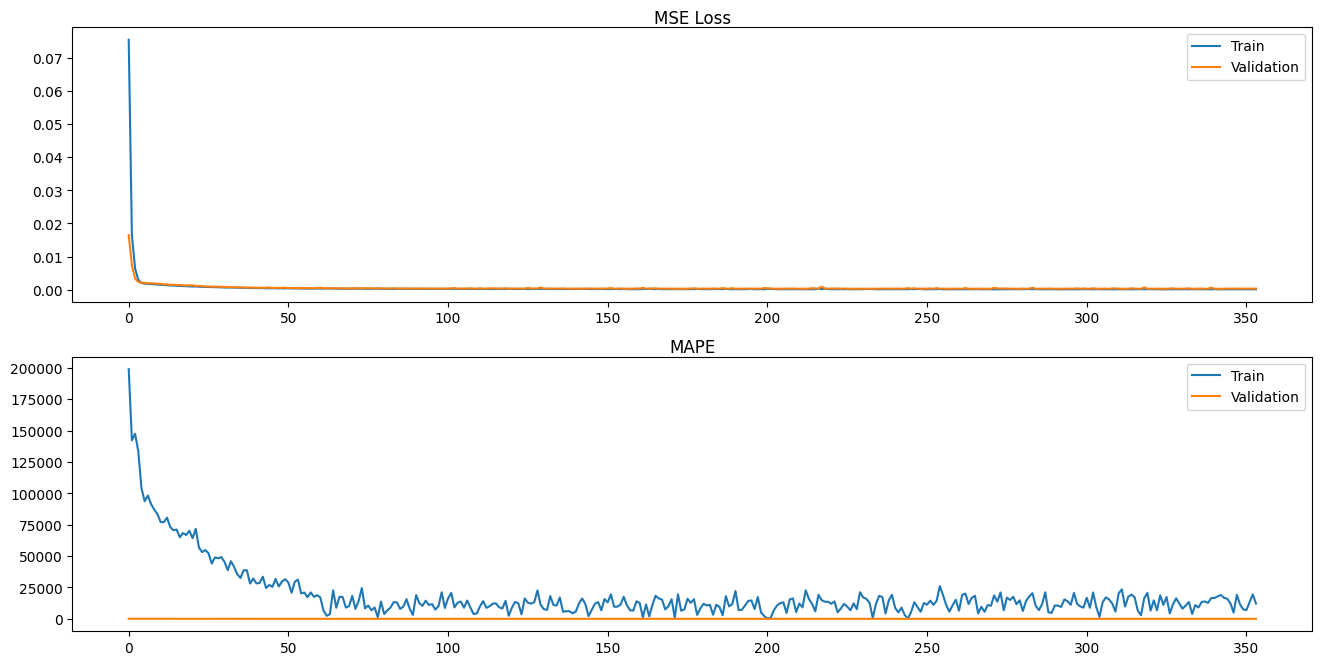

Bi-directional LSTM: [0.023] 0.0


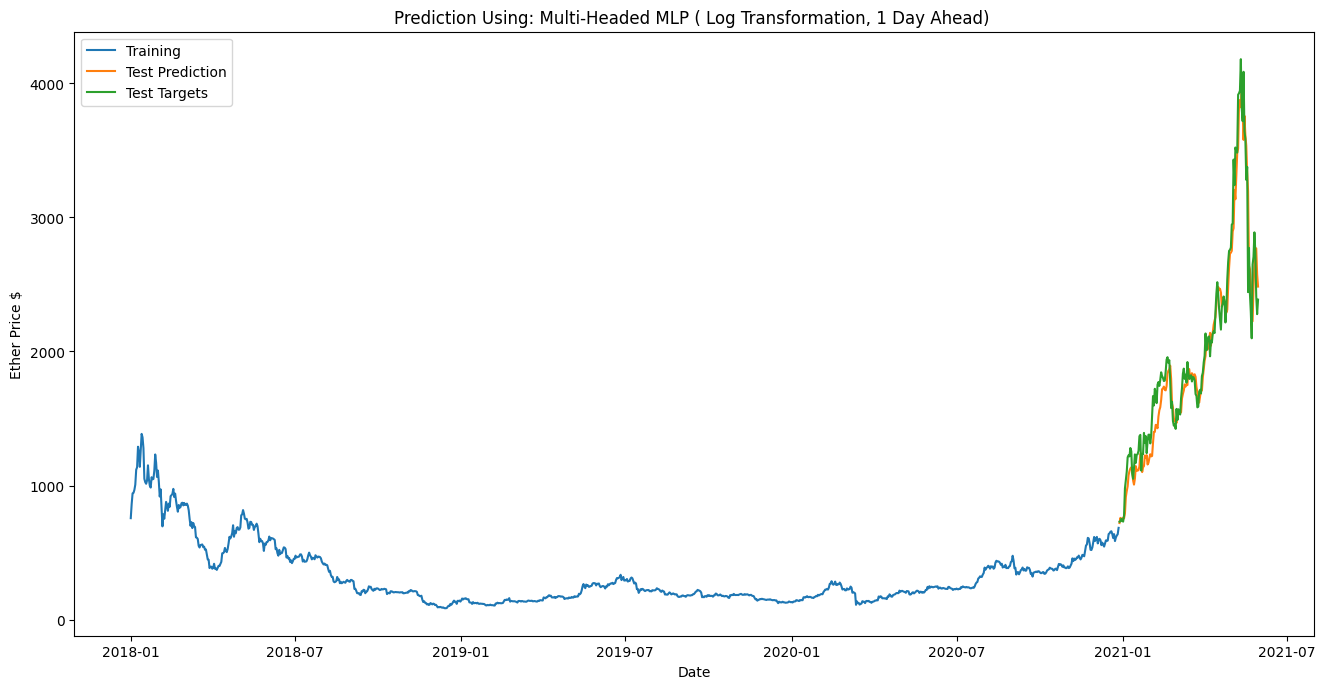

Total RMSE is:  171.8158093357487
Total MAPE is:  6.733512544546973
Runtime of the program is 69.03429555892944


In [82]:
import numpy as np
from numpy import split
from numpy import array
from numpy import array
import pandas as pd
from math import sqrt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = metrics.mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores



df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

n_input = 14
n_out = 1

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 


# convert history into inputs and outputs
# flatten data
sequences_train = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences_train, n_input, n_out)

sequences_test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
test_x, test_y= split_sequences(sequences_test, n_input, n_out)

train_x, validation_x, train_y, validation_y = train_test_split(train_x, train_y, test_size=0.1, random_state=2)

n_features = train_x.shape[2]

#--------------------------
# Multi-headed MLP
#--------------------------
'''ModelType='Multi-headed MLP'
# separate input data
train_x = [train_x[:, :, i] for i in range(n_features)]
validation_x = [validation_x[:, :, i] for i in range(n_features)]
test_x = [test_x[:, :, i] for i in range(n_features)]

# first input model
visible= [Input(shape=(n_input,)) for i in range(n_features)]
dense=[Dense(50, activation='relu', kernel_regularizer=l1(0.01))(visible[i]) for i in range(n_features)]
#Btc_normalization=[BatchNormalization()(dense[i]) for i in range(n_features)]
#noise=[GaussianNoise(0.1)(dense[i]) for i in range(n_features)]
# merge input models
merge = concatenate([dense[i] for i in range(n_features)])
output = Dense(n_out)(merge)
model_mlp = Model(inputs=[visible[i] for i in range(n_features)], outputs=output)
model_mlp.compile(optimizer='Adam', loss='mse', metrics='mape')

# fit model
#rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_delta=1E-7,verbose=1)
#callbacks=[rlrp],
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
# fit
history = model_mlp.fit(train_x, train_y, validation_data=(validation_x, validation_y),
batch_size=30, epochs=2000, callbacks=[es], verbose=0)

_, train_mape = model_mlp.evaluate(train_x, train_y, verbose=0)
_, test_mape = model_mlp.evaluate(test_x, test_y, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_mape, test_mape))
# plot loss learning curvesplt.figure(figsize=(16,8), dpi=100)
plt.figure(figsize=(16,8), dpi=100)
plt.subplot(211)
plt.title('MSE Loss', pad=-40)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
# plot accuracy learning curves
plt.subplot(212)
plt.title('MAPE', pad=-40)
plt.plot(history.history['mape'], label='Train')
plt.plot(history.history['val_mape'], label='Validation')
plt.legend()
plt.show()'''

#--------------------------
# Simple CNN
#--------------------------
'''ModelType='Simple CNN'
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(n_input,
n_features)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(500, activation='relu', kernel_regularizer=l1(0.01)))
model_cnn.add(Dense(n_out))
model_cnn.compile(optimizer='adam', loss='mse', metrics='mape')


# fit model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
# fit
history = model_cnn.fit(train_x, train_y, validation_data=(validation_x, validation_y),
batch_size=30, epochs=2000, callbacks=[es], verbose=0)

_, train_mape = model_cnn.evaluate(train_x, train_y, verbose=0)
_, test_mape = model_cnn.evaluate(test_x, test_y, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_mape, test_mape))
# plot loss learning curvesplt.figure(figsize=(16,8), dpi=100)
plt.figure(figsize=(16,8), dpi=100)
plt.subplot(211)
plt.title('MSE Loss', pad=-40)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
# plot accuracy learning curves
plt.subplot(212)
plt.title('MAPE', pad=-40)
plt.plot(history.history['mape'], label='Train')
plt.plot(history.history['val_mape'], label='Validation')
plt.legend()
plt.show()'''


#--------------------------
# Vanilla LSTM
#--------------------------

'''ModelType='Vanilla LSTM'
model_vlstm = Sequential()
model_vlstm.add(LSTM(64, activation='sigmoid', input_shape=(n_input, n_features)))
model_vlstm.add(Dense(n_out))
model_vlstm.compile(optimizer='adam', loss='mse', metrics='mape')

# fit model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
# fit
history = model_vlstm.fit(train_x, train_y, validation_data=(validation_x, validation_y),
batch_size=30, epochs=400, callbacks=[es], verbose=0)

_, train_mape = model_vlstm.evaluate(train_x, train_y, verbose=0)
_, test_mape = model_vlstm.evaluate(test_x, test_y, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_mape, test_mape))
# plot loss learning curvesplt.figure(figsize=(16,8), dpi=100)
plt.figure(figsize=(16,8), dpi=100)
plt.subplot(211)
plt.title('MSE Loss', pad=-40)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
# plot accuracy learning curves
plt.subplot(212)
plt.title('MAPE', pad=-40)
plt.plot(history.history['mape'], label='Train')
plt.plot(history.history['val_mape'], label='Validation')
plt.legend()
plt.show()'''


#--------------------------
# Stacked LSTM
#--------------------------
# define model

'''ModelType='Stacked LSTM'
model_slstm = Sequential()
model_slstm.add(LSTM(50, activation='sigmoid', return_sequences=True, input_shape=(n_input,n_features)))
model_slstm.add(LSTM(25, activation='sigmoid'))
model_slstm.add(Dense(n_out))
model_slstm.compile(optimizer='adam', loss='mse', metrics='mape')

# fit model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# fit
history = model_slstm.fit(train_x, train_y, validation_data=(validation_x, validation_y),
batch_size=30, epochs=200, callbacks=[es], verbose=0)

_, train_mape = model_slstm.evaluate(train_x, train_y, verbose=0)
_, test_mape = model_slstm.evaluate(test_x, test_y, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_mape, test_mape))
# plot loss learning curvesplt.figure(figsize=(16,8), dpi=100)
plt.figure(figsize=(16,8), dpi=100)
plt.subplot(211)
plt.title('MSE Loss', pad=-40)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
# plot accuracy learning curves
plt.subplot(212)
plt.title('MAPE', pad=-40)
plt.plot(history.history['mape'], label='Train')
plt.plot(history.history['val_mape'], label='Validation')
plt.legend()
plt.show()'''


#--------------------------
# Bidirectional LSTM
#--------------------------
# define model

ModelType='Bidirectional LSTM'
model_bdlstm = Sequential()
model_bdlstm.add(Bidirectional(LSTM(16, activation='sigmoid'), input_shape=(n_input, n_features)))
model_bdlstm.add(Dense(n_out))
model_bdlstm.compile(optimizer='adam', loss='mse', metrics='mape')

# fit model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
# fit
history = model_bdlstm.fit(train_x, train_y, validation_data=(validation_x, validation_y),
batch_size=30, epochs=400, callbacks=[es], verbose=0)

_, train_mape = model_bdlstm.evaluate(train_x, train_y, verbose=0)
_, test_mape = model_bdlstm.evaluate(test_x, test_y, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_mape, test_mape))
# plot loss learning curvesplt.figure(figsize=(16,8), dpi=100)
plt.figure(figsize=(16,8), dpi=100)
plt.subplot(211)
plt.title('MSE Loss', pad=-40)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
# plot accuracy learning curves
plt.subplot(212)
plt.title('MAPE', pad=-40)
plt.plot(history.history['mape'], label='Train')
plt.plot(history.history['val_mape'], label='Validation')
plt.legend()
plt.show()

#--------------------------
# Encoder-Decoder LSTM
#--------------------------
# define model
'''
ModelType='Encoder-Decoder LSTM'
model_edlstm = Sequential()
model_edlstm.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_edlstm.add(RepeatVector(n_out))
model_edlstm.add(LSTM(100, activation='relu', return_sequences=True))
model_edlstm.add(TimeDistributed(Dense(1)))
model_edlstm.compile(optimizer='adam', loss='mse')
# fit model
model_edlstm.fit(train_x, train_y, epochs=200, verbose=0)'''


# evaluate All model
# history is a list of weekly data
HISTORY = [x for x in train]
Model_Names= [('mlp', 'Multi-Headed-MLP'), ('vlstm', 'Vanilla-LSTM'), ('slstm', 'Stacked-LSTM'), 
            ('bdlstm', 'Bi-Directional-LSTM'), ('edlstm', 'Encoder-Decoder-LSTM')]

# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    # flatten data
    data = array(HISTORY)
    data = data.reshape((data.shape[0] * data.shape[1] , data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into n input arrays
    if ModelType == 'Multi-headed MLP':
        input_x=[input_x[:, i].reshape((1, n_input)) for i in range(n_features)] 
    else:
        input_x = input_x.reshape((1, n_input, n_features))
    yhat = model_bdlstm.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    HISTORY.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    


name='Bi-directional LSTM'
# summarize_scores
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % (name, score, s_scores))


#days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
#plt.plot(days, scores, marker='o', label='MLP')
#plt.show()         

# Plot normalized outputs
#plt.plot(train_index, y_train, label='Training-norm')
#plt.plot(test_index, predictions.reshape(predictions.shape[0]*predictions.shape[1]), label='Test Prediction-norm')
#plt.plot(test_index, test[:, :, 0].reshape(test.shape[0]*test.shape[1]), label='Test Targets-norm')
#plt.legend()
#plt.show()

# Plot rescaled outputs
y_trainrev=np.exp(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])-1
y_testrev=np.exp(scaler.inverse_transform(test.reshape(test.shape[0]*test.shape[1],test.shape[2] ))[:,0])-1
y_predrev=np.exp(scaler.inverse_transform(np.concatenate((predictions.reshape(predictions.shape[0]*predictions.shape[1]).reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])-1


plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Multi-Headed MLP ( Log Transformation, 1 Day Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

    # end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
mape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total MAPE is: ' , mape)
# total time taken
print(f"Runtime of the program is {end - start}")

In [83]:
# serialize model to JSON

from tensorflow.keras.models import model_from_json
model_json = model_bdlstm.to_json()
with open("model_bdlstm1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_bdlstm.save_weights("model_bdlstm1.h5")
print("Saved model to disk")

Saved model to disk
